<a href="https://colab.research.google.com/github/tonytieger/w210-capstone-project/blob/master/runLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#SUMMARY
Our capstone project attempts to implement openly available research and literature around "Drowsy" driver detection through temporal and image recognition models.

#Model Development

## CNN + Transfer Learning
- ~1000 images from each video that focus on the region of interest
- Face, eyes and mouth are focus regions, important for drowsiness detection. 
- Pertinent facial features are extracted using the inception V3 model. 
- Transfer learning approach and trained on the images from step 2.

## LSTM Model
- Stitched features for videos is used for a sequential LSTM model.
- 2048 dimension vectors are passed into the LSTM model

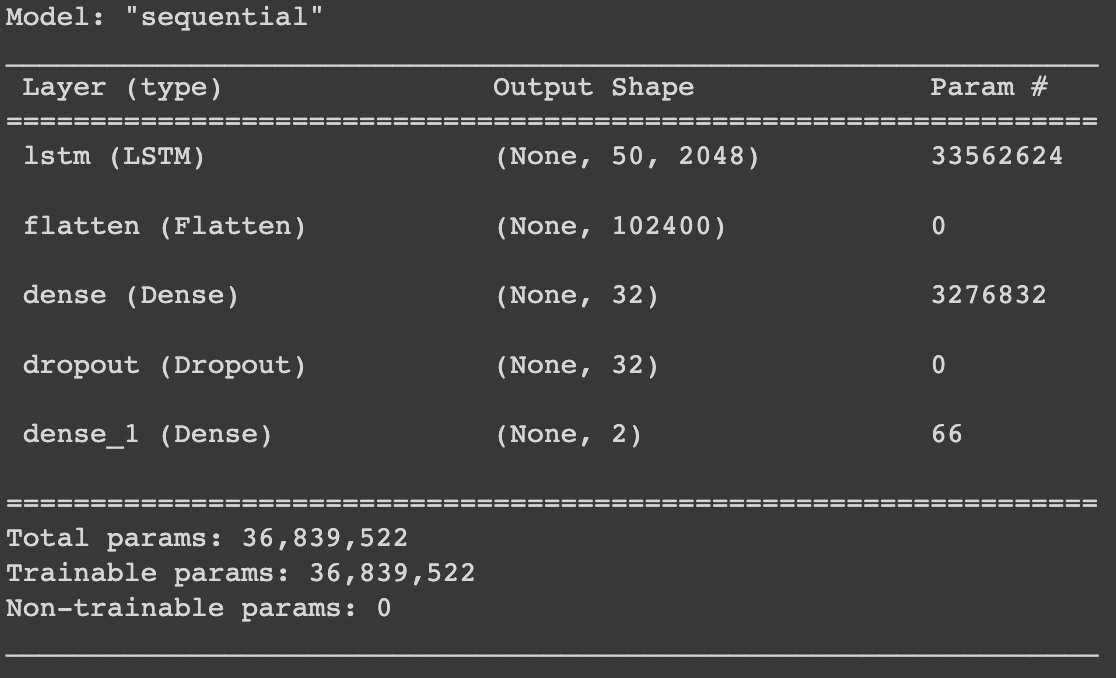

#Team :
Abby Bai, Saman Arabali, Sri Yanamandra, Tony Hwang, Amey Mahajan

#References : Code Repos and Literature
https://medium.com/@jaynishvaghela/driver-drowsiness-detection-using-lstm-network-2966c49a5400
https://github.com/jaynishvaghela/DriverDrowsinessDetection
https://github.com/nishagandhi/DrowsyDriverDetection

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import files
from google.colab import drive
import os
import pickle

drive.mount('/drive', force_remount=True)

google_drive_folder = '/drive/MyDrive/temporal/'

Mounted at /drive


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import pickle
import imutils
import os
import cv2
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os.path
import csv
import glob
import tensorflow as tf
import h5py as h5py
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
import natsort
import sys
import shutil
from scipy.sparse.construct import random
import random as rndm

from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical


In [4]:
trainPath = "/drive/MyDrive/temporal/SequenceOutput/newTraining/FullTraining"
sequencesInPlace = glob.glob(os.path.join(trainPath,"*.npy"))
sequencesForModel = natsort.natsorted(sequencesInPlace,reverse=False)

In [6]:
X, y = [], []

# trainingSeq = "/drive/MyDrive/temporal/SequenceOutput/"
for f in sequencesForModel:
  # if ("_50-features.npy" in f or "_100-features.npy" in f) and ("Fold1" in f and "Fold1" in f):
  # if "_50-features.npy" in f :
  label = f.split("/")[-1].split("_")[-2]
  if label == "Drowsy":
    label_cat = 1
  else:
    label_cat = 0
  sequence = np.load(f)
  X.append(sequence)
  y.append(to_categorical(label_cat,num_classes=2))


In [7]:
def getModelData(X,y,featureSize):
  train_size = int(len(X)*0.7)
  test_size = len(X) - train_size
  X_train = np.array(X)[:train_size]
  y_train = np.array(y)[:train_size]
  X_test = np.array(X)[train_size:]
  y_test = np.array(y)[train_size:]
  # print(X_train.shape)
  X_train = X_train.reshape(train_size,featureSize,2048)
  X_test = X_test.reshape(test_size,featureSize,2048)


  # labels_train = y_train.reshape(-1,1)
  # labels_test = y_test.reshape(-1,1)
  
  return X_train, y_train, X_test, y_test

X_train, labels_train, X_test, labels_test = getModelData(X, y, 50)

In [ ]:
X_train.shape, labels_train.shape, X_test.shape, labels_test.shape

In [4]:
model = Sequential()
model.add(LSTM(2048, return_sequences=True,
                input_shape=(50,2048),
                dropout= 0.3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# model.add(Flatten())
model.add(Dense(2, activation='softmax'))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# # model.add(Flatten())
# model.add(Dense(2, activation='softmax'))




In [ ]:
model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=6, mode='min', restore_best_weights=True)
# bc = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.00005),
                          metrics=['accuracy'])

history = model.fit(X_train,labels_train,batch_size=32,validation_data=(X_test, labels_test),verbose=1,callbacks=[es],epochs=100)

In [ ]:
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

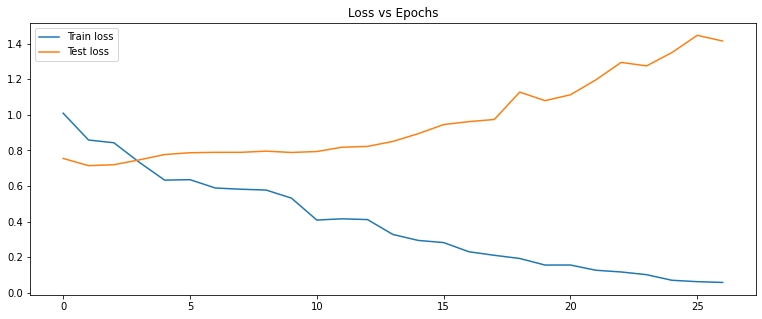

In [ ]:
plt.figure(figsize=(13,5))
plt.title("Loss vs Epochs")
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
predicted_classes=[]
for i in range(len(labels_test)):
  predicted_classes.append(np.argmax(y_pred[i]))

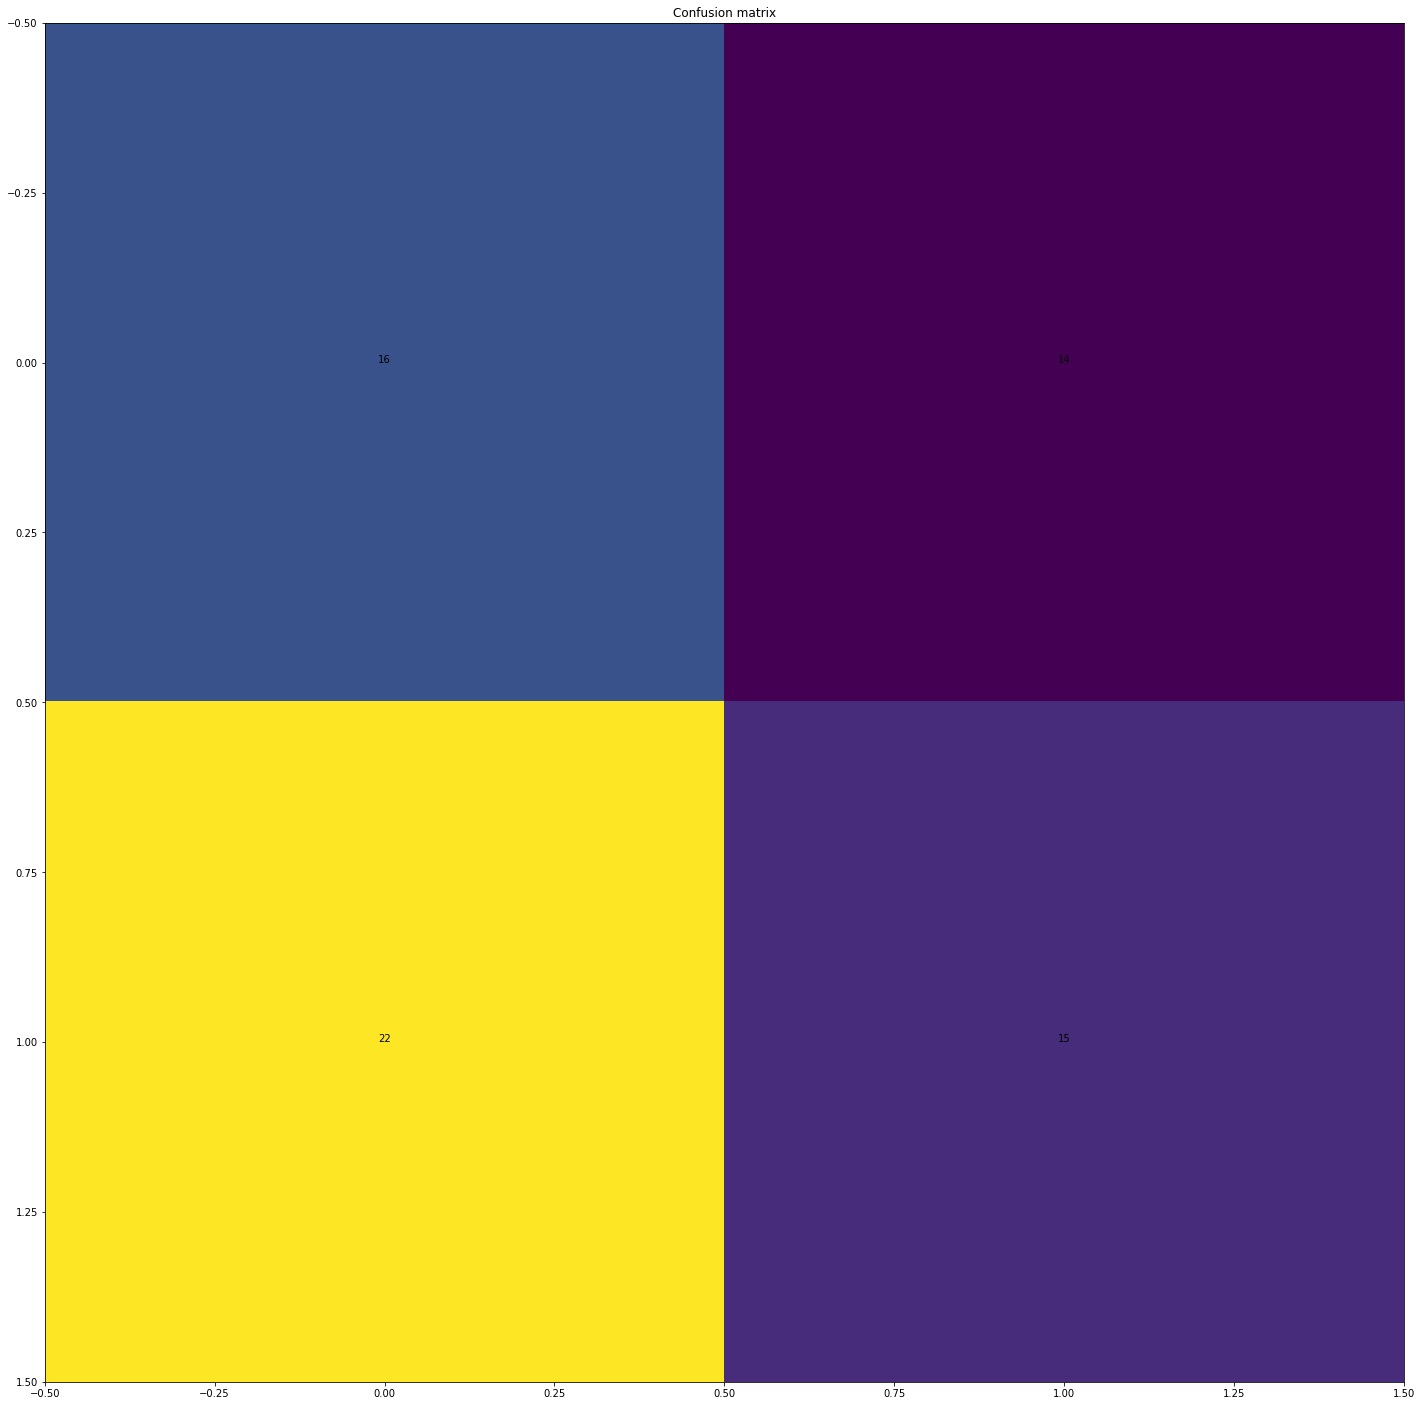

In [ ]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(labels_test, predicted_classes,labels=[0,1])
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()